# **PREDDICIÓN DE ACCIDENTES CEREBRO VASCULARES MEDIANTE RANDOM FOREST**

En el presente proyecto se analiza la implementación de un algorito de clasificación para determinar posibles casos de afecciones cerebro vasculares mediante un algoritmo de clasificación.

Dado que el dataset obtenido desde Kaggle: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset, se tiene algunos casos etiquetados con afecciones positivas en este tipo de patologías. Mediante el analisis de sus variables se intenta predecir posibles casos positivos.

# **EDA**

In [556]:
#importamos las librerias necesarias
import pandas as pd
import warnings
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.stats import variation
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [557]:
#El primer paso es descargar el archivo, guardarlo en drive y finalmente leerlo con pd.read_csv.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [558]:
#instanciamos el dataset
df = pd.read_csv('/content/drive/MyDrive/DataSets/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [559]:
conteo_valores = df['stroke'].value_counts()
print(conteo_valores)

stroke
0    4861
1     249
Name: count, dtype: int64


In [560]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Una vez montado el dataset se describe las variables con la función info, donde se detalla las caracteristicas del Data Frame encontrando:

1. id, El id del paciente
2. gender, Genero
3. age, Edad
4. hypertension, Clasificacion de hipertención (Yes or No)
5. heart_disease, Cardiopatias (Yes or No)
6. ever_married, Si ha contraído matrimonio (Yes or No)
7. work_type, El tipo de trabajo que realiza
8. Residence_type, El lugar de residencia
9. avg_glocose_level, El promedio del nivel de glucosa
10. bmi, Indice de masa corporal
11. smoking_status, Si es fumador (Yes or No)
12. stroke, Accidente cerebro vascular (Yes or No)

# **Completitud de los datos**
En cuanto a la completitud de los datos, se ha encontrado que en el apartado bmi contiene 201 campos nulos.

In [561]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Se verifica la distribución de dicha variable para tener una idea de que metodo elegir para imputar valores.

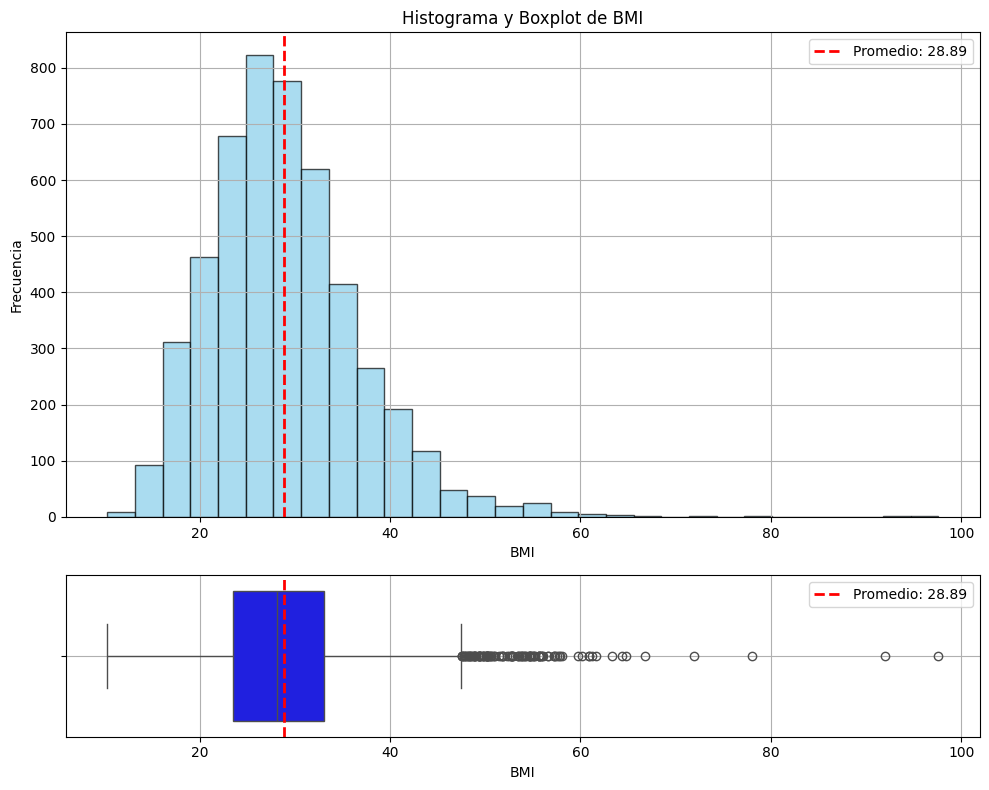

In [562]:
# Filtrar valores nulos para evitar errores
df_clean = df['bmi'].dropna()

# Calcular el promedio
mean_value = np.mean(df_clean)

# Crear figura y subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

axes[0].hist(df_clean, bins=30, edgecolor='black', color='skyblue', alpha=0.7)
axes[0].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {mean_value:.2f}')
axes[0].set_xlabel('BMI')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Histograma y Boxplot de BMI')
axes[0].legend()
axes[0].grid(True)

sns.boxplot(x=df_clean, color='blue', ax=axes[1])
axes[1].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Promedio: {mean_value:.2f}')
axes[1].set_xlabel('BMI')
axes[1].legend()
axes[1].grid(True)

# Ajustar espacio entre subplots
plt.tight_layout()
plt.show()

Tras realizar el analisis y observar que el bmi es una de los campos mas relevantes para detectar los ataques cerebro vasculares, he decidido abordar los valores NAN en este campo rellenandolos con el valor medio, a consideración dejaría que en posteriori realizar una regresión linear o un random forest para poder predecir estos valores.

In [563]:
#Rellena con la mediana los valores NAN
mean_value = df['bmi'].mean()
df['bmi'].fillna(mean_value, inplace=True)

<ipython-input-563-b3045dbcbcb1>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(mean_value, inplace=True)


In [564]:
nan_counts = df.isnull().sum()
print(nan_counts)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


Dado que el dataset original contiene valores que ya se encuentra con labels como 0 y 1 antes de poder verificar anomalías los volvemos a columnas categoricas Yes o No para poder graficarlos

In [565]:
#cambiar valores por yes y no
columnas_a_cambiar = ['hypertension', 'heart_disease', 'stroke']
df[columnas_a_cambiar] = df[columnas_a_cambiar].replace({0: 'No', 1: 'Yes'})
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,No,Yes,Yes,Private,Urban,228.69,36.600000,formerly smoked,Yes
1,51676,Female,61.0,No,No,Yes,Self-employed,Rural,202.21,28.893237,never smoked,Yes
2,31112,Male,80.0,No,Yes,Yes,Private,Rural,105.92,32.500000,never smoked,Yes
3,60182,Female,49.0,No,No,Yes,Private,Urban,171.23,34.400000,smokes,Yes
4,1665,Female,79.0,Yes,No,Yes,Self-employed,Rural,174.12,24.000000,never smoked,Yes


In [566]:
#convertimos la columna age en un entero
df['age'] = df['age'].astype(int)

In [567]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   int64  
 3   hypertension       5110 non-null   object 
 4   heart_disease      5110 non-null   object 
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   object 
dtypes: float64(2), int64(2), object(8)
memory usage: 479.2+ KB


In [568]:
#gráfico de cajas de los valores númericos
def plot_boxplots(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    # Definir el número de columnas y calcular las filas necesarias
    num_cols = 4
    num_rows = math.ceil(len(numeric_cols) / num_cols)

    # Configuración del tamaño de la figura
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=df[col], ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Eliminar los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

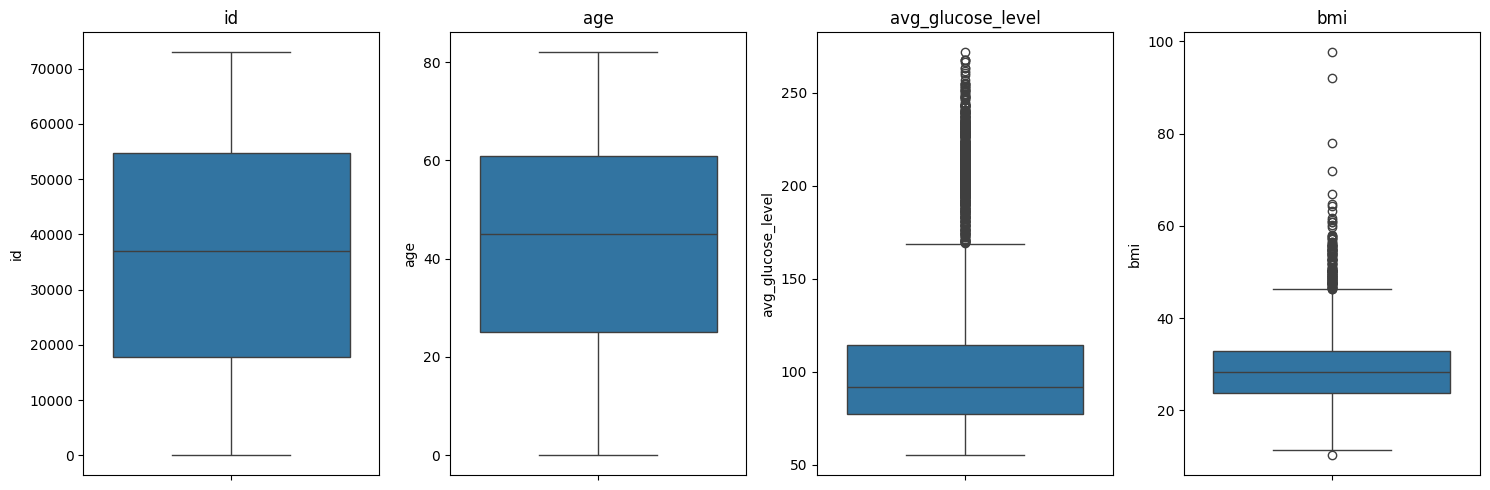

In [569]:
plot_boxplots(df)

In [570]:
# histogramas de los valores númericos
def plot_histograms(df):
    # Filtrar solo las columnas numéricas
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_cols:
        print("No hay columnas numéricas en el DataFrame.")
        return

    num_cols = 4
    num_rows = math.ceil(len(numeric_cols) / num_cols)
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
    axes = axes.flatten()  # Aplanar la matriz de ejes para fácil iteración

    for i, col in enumerate(numeric_cols):
        sns.histplot(df[col], kde=True, ax=axes[i])  # kde=True agrega una línea de densidad
        axes[i].set_title(col)
        axes[i].set_xlabel('')

    # Elimina los ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

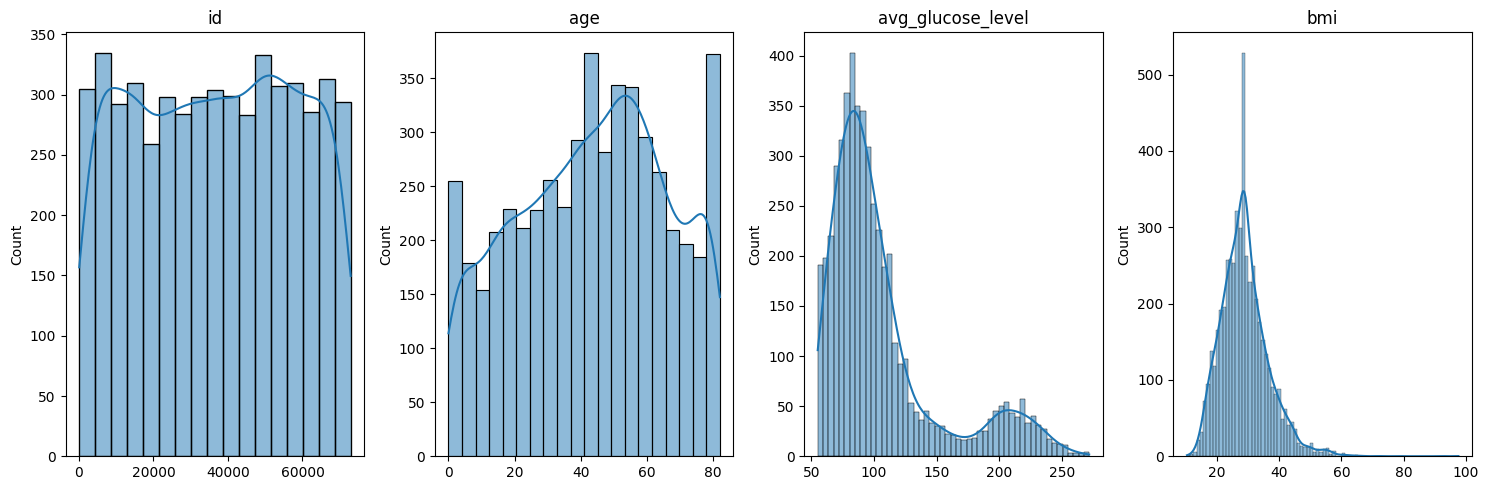

In [571]:
plot_histograms(df)

In [572]:
df.describe()

,id,age,avg_glucose_level,bmi
count,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.215264,106.147677,28.893237
std,21161.721625,22.633866,45.283560,7.698018
min,67.000000,0.000000,55.120000,10.300000
25%,17741.250000,25.000000,77.245000,23.800000
50%,36932.000000,45.000000,91.885000,28.400000
75%,54682.000000,61.000000,114.090000,32.800000
max,72940.000000,82.000000,271.740000,97.600000


De inicio asumí que en edad al contener valores como 0 estaban mal ingresados, pero tras observar la categoría children en el apartado work_type es deducido que se tratan de ninos.

In [573]:
from math import ceil
def graficos_eda_categoricos(cat, columnas_excluir=[]):
    # Filtrar el DataFrame para excluir las columnas numéricas y las especificadas
    cat = cat.drop(columns=columnas_excluir)  # Excluir las columnas manualmente
    cat = cat.select_dtypes(exclude=['number'])  # Excluir las columnas numéricas

    filas = ceil(cat.shape[1] / 3)
    f, ax = plt.subplots(nrows=filas, ncols=3, figsize=(12, filas * 3))
    ax = ax.flat

    # Crea los gráficos de barras para cada columna
    for cada, variable in enumerate(cat.columns):
        cat[variable].value_counts().plot.barh(ax=ax[cada], color='skyblue')
        ax[cada].set_title(variable, fontsize=10, fontweight="bold")  # Fuente más pequeña
        ax[cada].tick_params(labelsize=8)  # Ajustamos el tamaño de las etiquetas

    # Ajusta el layout para evitar superposición
    plt.tight_layout()
    plt.show()

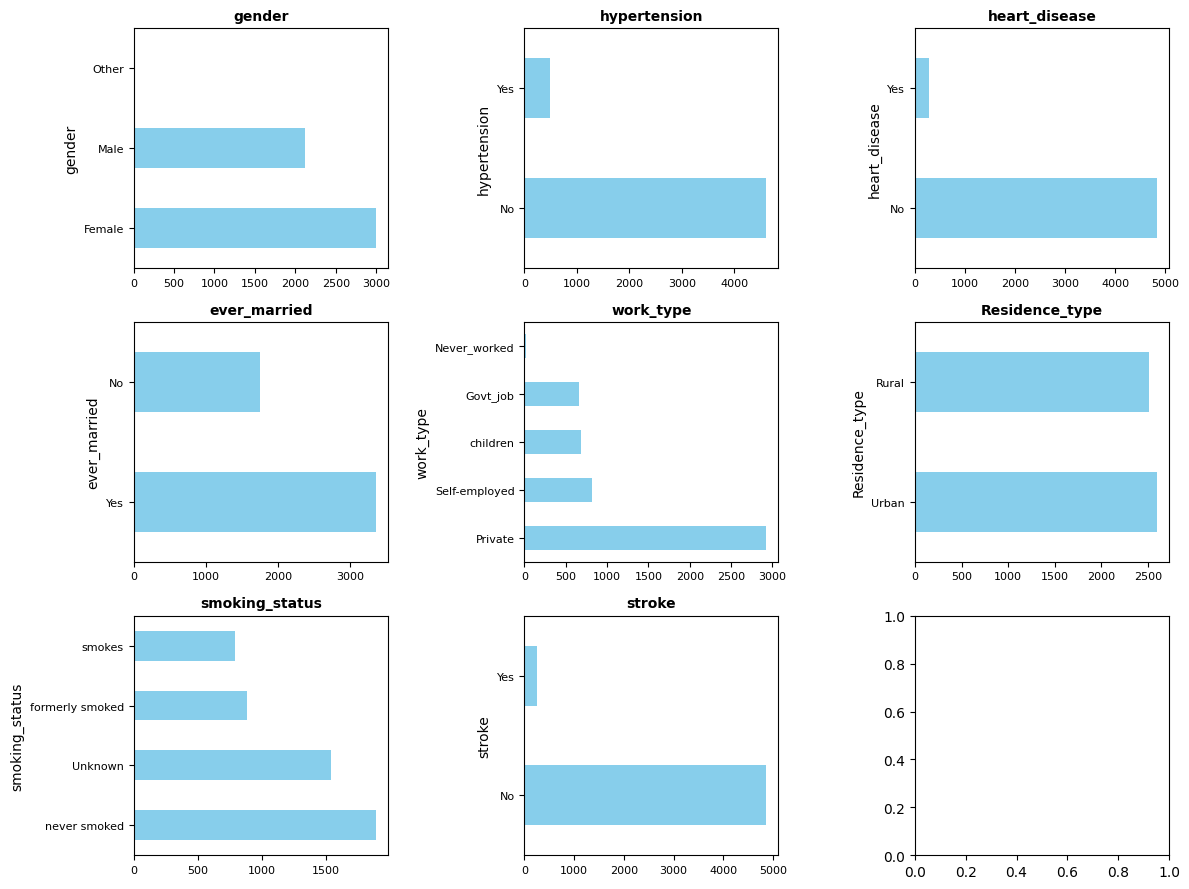

In [574]:
graficos_eda_categoricos(df)

Podemos observar que la variable objetivo se encuentra sumamente desbalanceada casí un 96% a 4% de esta lo cual nos puede contraer problemas al momento de realizar el entrenamiento del modelo

# **PREPROCESAMIENTO DE DATOS**

In [575]:
# ESCALADORES
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Standard Scaler
escalador = StandardScaler()
df[numeric_cols] = escalador.fit_transform(df[numeric_cols]) # Tomar valores numericos'''

In [576]:
df = df.drop('id', axis=1)

In [577]:
df.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,1.050950,No,Yes,Yes,Private,Urban,2.706375,1.001234e+00,formerly smoked,Yes
1,Female,0.785835,No,No,Yes,Self-employed,Rural,2.121559,4.615554e-16,never smoked,Yes
2,Male,1.625367,No,Yes,Yes,Private,Rural,-0.005028,4.685773e-01,never smoked,Yes
3,Female,0.255604,No,No,Yes,Private,Urban,1.437358,7.154182e-01,smokes,Yes
4,Female,1.581181,Yes,No,Yes,Self-employed,Rural,1.501184,-6.357112e-01,never smoked,Yes
5,Male,1.669553,No,No,Yes,Private,Urban,1.768195,1.387026e-02,formerly smoked,Yes
6,Male,1.360251,Yes,Yes,Yes,Private,Rural,-0.796342,-1.939958e-01,never smoked,Yes
7,Female,1.139322,No,No,No,Private,Urban,-0.259671,-7.916107e-01,never smoked,Yes
8,Female,0.697463,No,No,Yes,Private,Rural,-0.662506,4.615554e-16,Unknown,Yes
9,Female,1.536995,No,No,Yes,Private,Urban,-1.050764,-6.097279e-01,Unknown,Yes


In [578]:
#Verifica los valores unicos
df.nunique()

,0
gender,3
age,83
hypertension,2
heart_disease,2
ever_married,2
work_type,5
Residence_type,2
avg_glucose_level,3979
bmi,419
smoking_status,4


# **ENCODING**

In [579]:
# Excluir la columna 'stroke' para OneHotEncoding
df_sin_stroke = df.drop(columns=['stroke'])

# Realizar OneHotEncoding en las columnas tipo object
encoder = OneHotEncoder(sparse_output=False)  # `sparse=False` para obtener un DataFrame
df_encoded = encoder.fit_transform(df_sin_stroke.select_dtypes(include=['object']))

# Convertir el resultado en un DataFrame
df_encoded = pd.DataFrame(df_encoded, columns=encoder.get_feature_names_out(df_sin_stroke.select_dtypes(include=['object']).columns))

# Aplicar LabelEncoder a la columna 'stroke'
label_encoder = LabelEncoder()
df['stroke'] = label_encoder.fit_transform(df['stroke'])

# Concatenar los DataFrames: los datos codificados y la columna 'stroke' con LabelEncoding
df_final = pd.concat([df_encoded, df['stroke']], axis=1)

# Ver el resultado
df_final.head()


,gender_Female,gender_Male,gender_Other,hypertension_No,hypertension_Yes,heart_disease_No,heart_disease_Yes,ever_married_No,ever_married_Yes,work_type_Govt_job,...,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,stroke
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
2,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


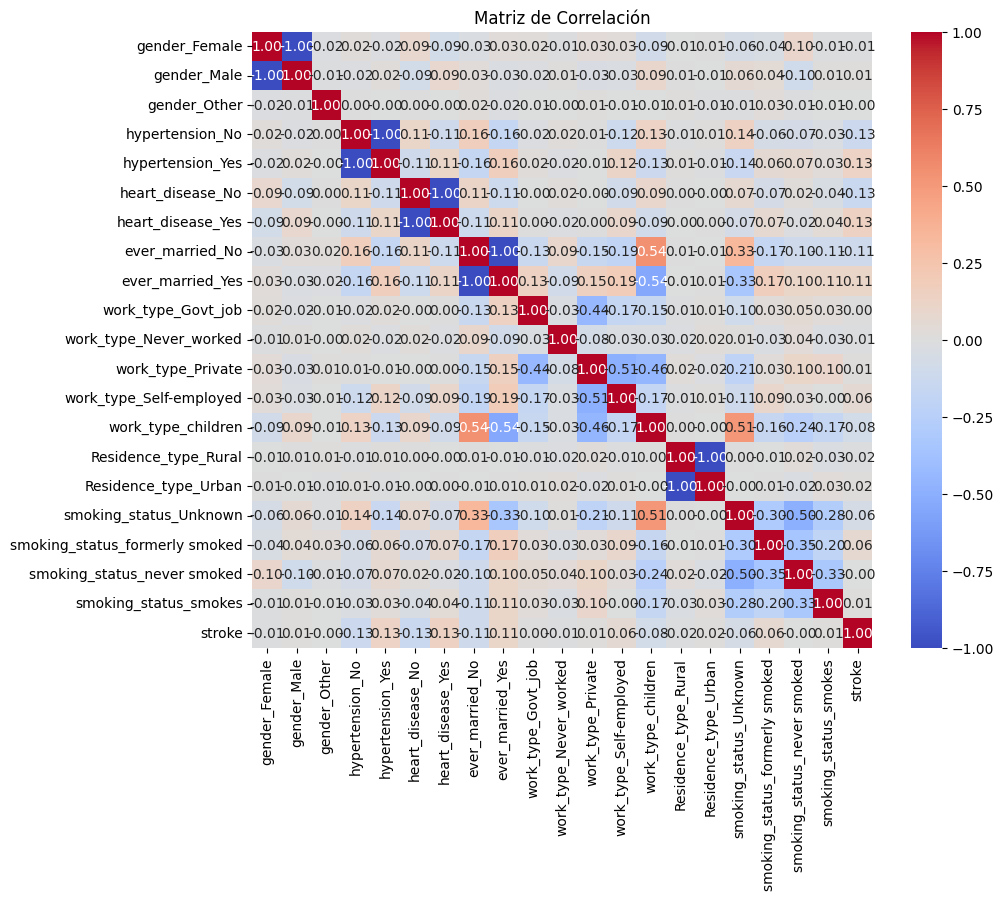

In [580]:
# Calcular la matriz de correlación solo para columnas numéricas
corr_matrix = df_final.select_dtypes(include=['number']).corr()

# Crear el mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Matriz de Correlación')
plt.show()

# **División de los datos**

In [581]:
#'Churn' es la variable dependiente, así que elimínala. Copiando el resto de las columnas a `X`.
X = df_final.drop('stroke', axis=1)

#Copiando la columna 'Churn' por sí sola en el DataFrame `y`. Esta es la variable dependiente.
y = df_final[['stroke']]

# **RANDOM FOREST**

In [543]:
classes = np.unique(y['stroke'])  # Get unique values from the 'stroke' column of the DataFrame
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y['stroke'])
weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

In [514]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=1)

In [549]:
#Se instancia el modelo
rf_model = RandomForestClassifier(n_estimators=100, class_weight=weights_dict, random_state=16)

In [550]:
#Entrena el modelo con random forest
rf_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight={0: 0.5256120139888911,
                                     1: 10.261044176706827},
                       random_state=16)

In [551]:
#Instancia las predicciones del modelo
y_pred_rf = rf_model.predict(X_test)

In [552]:
# Exactitud
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf}")

# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix_rf)

# Reporte de clasificación
class_report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report:")
print(class_report_rf)

Accuracy: 0.773972602739726
Confusion Matrix:
[[1547  391]
 [  71   35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.80      0.87      1938
           1       0.08      0.33      0.13       106

    accuracy                           0.77      2044
   macro avg       0.52      0.56      0.50      2044
weighted avg       0.91      0.77      0.83      2044



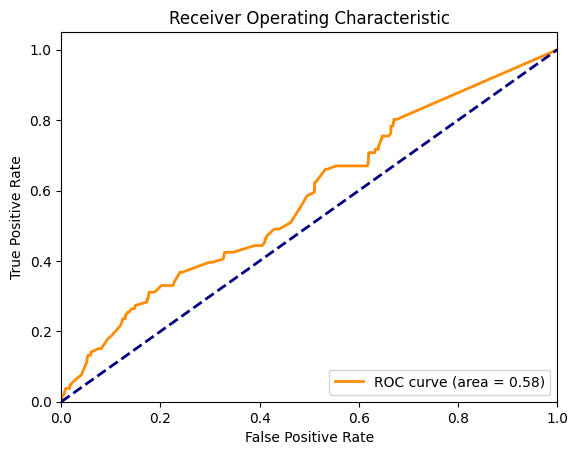

In [553]:
# Obtener las probabilidades de predicción solo para la clase positiva (stroke = 'Yes')
pred = rf_model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Línea diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

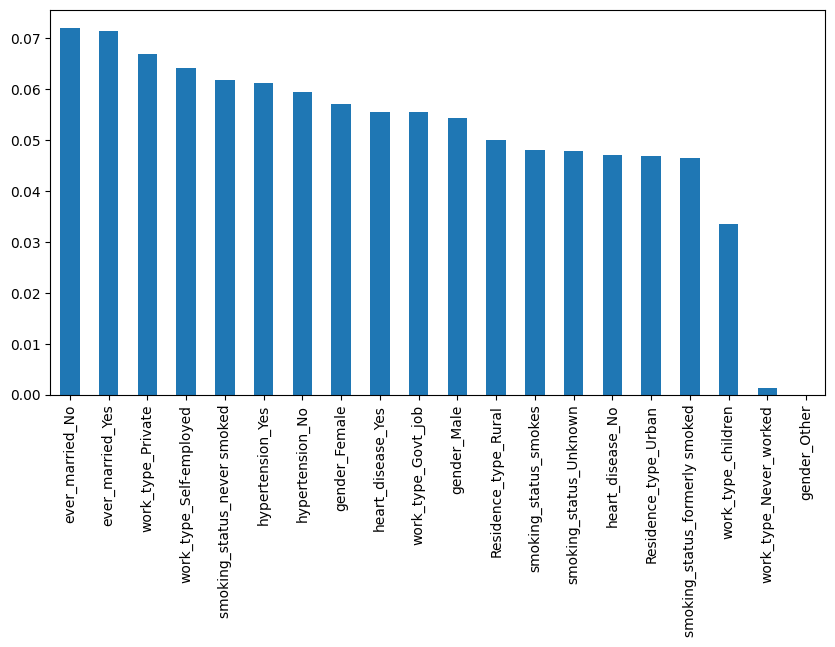

In [554]:
pd.Series(rf_model.feature_importances_,index = X_test.columns).sort_values(ascending = False).plot(kind = 'bar', figsize = (10,5));

# **RED NEURONAL**

In [583]:
import torch
import torch.nn as nn
import torch.optim as optim

X = df_final.drop(columns=['stroke']).values  # Reemplaza 'variable_objetivo' con el nombre real
y = df_final['stroke'].values
# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convertir a tensores de PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Definir la red neuronal
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_layer = nn.Linear(input_size, 64)  # Capa oculta con 64 neuronas
        self.output_layer = nn.Linear(64, 1)  # Capa de salida (1 neurona porque la salida está entre 0 y 1)
        self.activation = nn.ReLU()  # Función de activación ReLU

    def forward(self, x):
        x = self.activation(self.hidden_layer(x))
        x = torch.sigmoid(self.output_layer(x))  # Usamos sigmoide para la salida entre 0 y 1
        return x

# Inicializar la red
input_size = X_train.shape[1]  # Número de características de entrada (20 en tu caso)
model = NeuralNetwork(input_size)

# Definir el optimizador y la función de pérdida
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()  # Función de pérdida para clasificación binaria

# Entrenamiento de la red neuronal
num_epochs = 100  # Número de épocas
for epoch in range(num_epochs):
    model.train()  # Establecer el modelo en modo de entrenamiento
    optimizer.zero_grad()  # Reiniciar los gradientes
    outputs = model(X_train_tensor)  # Realizar la predicción
    loss = criterion(outputs, y_train_tensor)  # Calcular la pérdida
    loss.backward()  # Calcular el gradiente
    optimizer.step()  # Actualizar los pesos

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluación del modelo
model.eval()  # Establecer el modelo en modo de evaluación
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred = y_pred.round()  # Convertir la salida en 0 o 1

    # Calcular F1-score y Recall para la clase 1
    f1 = f1_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)

    print(f"F1-Score (Clase 1): {f1:.4f}")
    print(f"Recall (Clase 1): {recall:.4f}")

Epoch [10/100], Loss: 0.6378
Epoch [20/100], Loss: 0.5304
Epoch [30/100], Loss: 0.4343
Epoch [40/100], Loss: 0.3485
Epoch [50/100], Loss: 0.2793
Epoch [60/100], Loss: 0.2319
Epoch [70/100], Loss: 0.2049
Epoch [80/100], Loss: 0.1919
Epoch [90/100], Loss: 0.1862
Epoch [100/100], Loss: 0.1835
F1-Score (Clase 1): 0.0000
Recall (Clase 1): 0.0000
